In [ ]:
!nvidia-smi

Fri Jan  7 08:48:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = models.vgg16(pretrained = True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    #normalize the images with imagenet data mean and std
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/imagenet", transform = transform)

In [ ]:
batch_size=1
evalloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [ ]:
dataiter = iter(evalloader)
images, labels = dataiter.next()


In [ ]:
# We need a function to show images now that they have been converted to tensors
def imshow(image):
  mean = np.asarray([0.485, 0.456, 0.406]).reshape(3,1,1)
  std = np.asarray([0.229, 0.224, 0.225]).reshape(3,1,1)
  np_image = np.multiply(image.numpy(), std) + mean
  plt.imshow(np.transpose(np_image, (1,2,0)))
  plt.show()

In [ ]:
def deprocess(image):
  mean = np.asarray([0.485, 0.456, 0.406]).reshape(3,1,1)
  std = np.asarray([0.229, 0.224, 0.225]).reshape(3,1,1)
  np_image = np.multiply(image, std) + mean
  return np_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


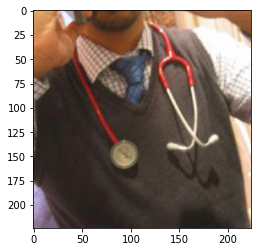

In [ ]:
images, labels = next(dataiter)

img = torchvision.utils.make_grid(images)
imshow(img)

In [ ]:
outputs = model(images)
outputs = torch.nn.functional.softmax(outputs, dim = 1)
prob_no_occ, pred = torch.max(outputs.data, 1)
prob_no_occ = prob_no_occ[0].item()
print(prob_no_occ)

0.6712237596511841


In [ ]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):  
    width, height = image.shape[-2], image.shape[-1]
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride)) 
    heatmap = torch.zeros((output_height, output_width))    
    for h in range(0, height):
        for w in range(0, width):            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            output = model(input_image)
            output = torch.nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            heatmap[h, w] = prob 

    return heatmap

In [ ]:
heatmap = occlusion(model, images, pred[0].item(), 32, 14)

In [ ]:
import seaborn as sns

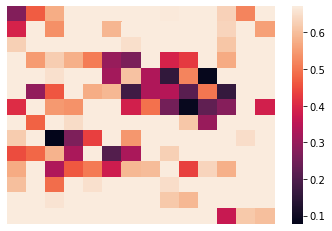

In [ ]:
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()


In [ ]:
from skimage.transform import resize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


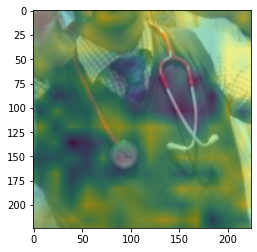

In [ ]:
upsample = resize(heatmap, (224,224),preserve_range=True)
plt.imshow(np.transpose(deprocess(img.numpy()),(1,2,0)))
plt.imshow(upsample, alpha = 0.5)
plt.show()